In [52]:
# Data wrangling
import pandas as pd 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns 

# Date wrangling
import datetime

# Math operations
import numpy as np

# Random sampling
import random

# mlp for multi-output regression
from numpy import mean
from numpy import std
from itertools import combinations_with_replacement

# Data loading and saving 
import pickl
import matplotlib.dates as mdates

In [25]:
df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
df = pd.concat([df2005, df2006], axis=0)

In [27]:
ALL_DATES = df.Date

In [51]:
ALL_DATES[:int(0.12*len(ALL_DATES))]

0     01.05.2005
1     02.05.2005
2     03.05.2005
3     04.05.2005
4     05.05.2005
5     06.05.2005
6     07.05.2005
7     08.05.2005
8     09.05.2005
9     10.05.2005
10    11.05.2005
11    12.05.2005
12    13.05.2005
13    14.05.2005
14    15.05.2005
15    16.05.2005
16    17.05.2005
17    18.05.2005
18    19.05.2005
19    20.05.2005
20    21.05.2005
21    22.05.2005
22    23.05.2005
23    24.05.2005
24    25.05.2005
25    26.05.2005
26    27.05.2005
27    28.05.2005
28    29.05.2005
29    30.05.2005
30    31.05.2005
31    01.06.2005
32    02.06.2005
33    03.06.2005
34    04.06.2005
35    05.06.2005
36    06.06.2005
37    07.06.2005
38    08.06.2005
Name: Date, dtype: object

In [50]:
ALL_DATES[int(0.12*len(ALL_DATES)):]

39     09.06.2005
40     10.06.2005
41     11.06.2005
42     12.06.2005
43     13.06.2005
          ...    
160    08.10.2006
161    09.10.2006
162    10.10.2006
163    11.10.2006
164    12.10.2006
Name: Date, Length: 291, dtype: object

In [31]:
def plot_data(df, title):
    x_values = [datetime.datetime.strptime(d,"%d.%m.%Y").date() for d in df['Date']]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))
    plt.plot(x_values,df['Sum_trap'])
    plt.gcf().autofmt_xdate()
    plt.title(title)
    plt.xlabel("Dzień")
    plt.ylabel("Liczba motyli")
    plt.savefig(title+".pdf")
    plt.show()

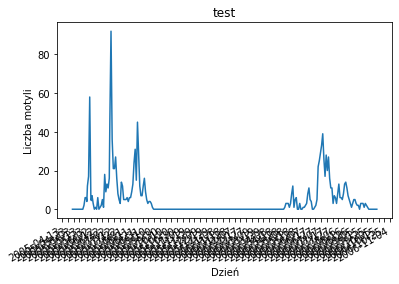

In [34]:
plot_data(df,"test")

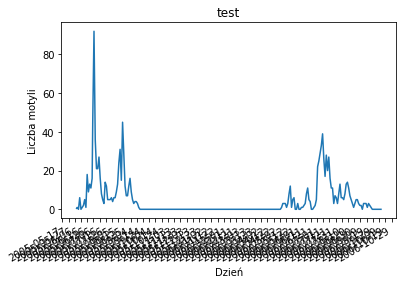

In [47]:
plot_data(df[int(0.12*len(ALL_DATES)):],"test")

In [53]:
def create_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=-1) -> tuple:
    """
    A method to create X and Y matrix from a time series array for the training of 
    deep learning models 
    """
    # Creating placeholder lists
    X, Y = [], []

    for i in range(len(ts) - lag - n_ahead):
        Y.append(ts[(i + lag), target_index])
        # X.append(ts[i:(i + lag)])

    ts = np.delete(ts, -1, axis=1)
    # Extracting the number of features that are passed from the array 
    n_features = ts.shape[1]
    if len(ts) - lag <= 0:
        X.append(np.concatenate(ts))
    else:
        for i in range(len(ts) - lag - n_ahead):
            X.append(np.concatenate(ts[i+1:(i + lag + 1)]))

    X = np.array(X)
    Y = np.array(Y)

    # Reshaping the X array to an RNN input shape 
    # X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

In [54]:
# Share of obs in testing 
test_share = 0.2

# The features used in the modeling 
# features_final = ['Avg', 'Dev', 'Rain', 'DD', 'DD Sum', 'CountTrap1', 'CountTrap2', 'CountTrap3', 'Sum']
features_final = ['Avg', 'DDSum', 'Rain', 'Sum_trap']

In [55]:
def normalize(X, axis=-1, order=2):
    """ Normalize the dataset X """
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [56]:
def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

In [57]:
def shuffle_data(X, y, seed=None):
    """ Random shuffle of the samples in X and y """
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

In [58]:
def k_fold_cross_validation_sets(X, y, k, shuffle=True):
    """ Split the data into k sets of training / test data """
    if shuffle:
        X, y = shuffle_data(X, y)

    n_samples = len(y)
    left_overs = {}
    n_left_overs = (n_samples % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    sets = []
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        sets.append([X_train, X_test, y_train, y_test])

    # Add left over samples to last set as training samples
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return np.array(sets)

In [59]:
def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

In [60]:
from __future__ import print_function, division
import numpy as np
import math


class l1_regularization():
    """ Regularization for Lasso Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w)

    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

class l1_l2_regularization():
    """ Regularization for Elastic Net Regression """
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, w):
        l1_contr = self.l1_ratio * np.linalg.norm(w)
        l2_contr = (1 - self.l1_ratio) * 0.5 * w.T.dot(w) 
        return self.alpha * (l1_contr + l2_contr)

    def grad(self, w):
        l1_contr = self.l1_ratio * np.sign(w)
        l2_contr = (1 - self.l1_ratio) * w
        return self.alpha * (l1_contr + l2_contr) 

class Regression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
    variables X. 
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))

    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

class LinearRegression(Regression):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations,
                                            learning_rate=learning_rate)
    def fit(self, X, y):
        # If not gradient descent => Least squares approximation of w
        if not self.gradient_descent:
            # Insert constant ones for bias weights
            X = np.insert(X, 0, 1, axis=1)
            # Calculate weights by least squares (using Moore-Penrose pseudoinverse)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)
        else:
            super(LinearRegression, self).fit(X, y)

class LassoRegression(Regression):
    """Linear regression model with a regularization factor which does both variable selection 
    and regularization. Model that tries to balance the fit of the model with respect to the training 
    data and the complexity of the model. A large regularization factor with decreases the variance of 
    the model and do para.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_regularization(alpha=reg_factor)
        super(LassoRegression, self).__init__(n_iterations, 
                                            learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(LassoRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(LassoRegression, self).predict(X)

class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations,
                                                learning_rate=learning_rate)

    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X, y)

    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X)

class RidgeRegression(Regression):
    """Also referred to as Tikhonov regularization. Linear regression model with a regularization factor.
    Model that tries to balance the fit of the model with respect to the training data and the complexity
    of the model. A large regularization factor with decreases the variance of the model.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001):
        self.regularization = l2_regularization(alpha=reg_factor)
        super(RidgeRegression, self).__init__(n_iterations, 
                                            learning_rate)

class PolynomialRidgeRegression(Regression):
    """Similar to regular ridge regression except that the data is transformed to allow
    for polynomial regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, gradient_descent=True):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        super(PolynomialRidgeRegression, self).__init__(n_iterations, 
                                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(PolynomialRidgeRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(PolynomialRidgeRegression, self).predict(X)

class ElasticNet(Regression):
    """ Regression where a combination of l1 and l2 regularization are used. The
    ratio of their contributions are set with the 'l1_ratio' parameter.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    l1_ration: float
        Weighs the contribution of l1 and l2 regularization.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree=1, reg_factor=0.05, l1_ratio=0.5, n_iterations=3000, 
                learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_l2_regularization(alpha=reg_factor, l1_ratio=l1_ratio)
        super(ElasticNet, self).__init__(n_iterations, 
                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(ElasticNet, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(ElasticNet, self).predict(X)

In [62]:
def prepare_data(features_final, test_share=0.2):
    df2005 = pd.read_csv("../data/forModels/clean_data_2005.csv", sep = ',')
    df2005.index = pd.to_datetime(df2005.Date, format="%d.%m.%Y")
    df2005 = df2005.drop(['Date'], axis=1)

    df2006 = pd.read_csv("../data/forModels/clean_data_2006.csv", sep = ',')
    df2006.index = pd.to_datetime(df2006.Date, format="%d.%m.%Y")
    df2006 = df2006.drop(['Date'], axis=1)

    df = pd.concat([df2005, df2006], axis=0)

    ts = df[features_final]

    nrows = ts.shape[0]

    # Spliting into train and test sets
    train = ts[0:int(nrows * (1 - test_share))]
    test = ts[int(nrows * (1 - test_share)):]

    # Scaling the data 
    train_mean = train.mean()
    train_std = train.std()

    train = (train - train_mean) / train_std
    test = (test - train_mean) / train_std
#     print(f"LEN FOR DF TRAINT {len(train)}")
#     print(f"LEN FOR DF TEST {len(test)}")
#     print(f"SUM {len(train) + len(test)}")
    # Creating the final scaled frame 
    ts_s = pd.concat([train, test])
    return ts_s

In [63]:
def make_experements(lags: list, iterations_list: list, days_ahead: int):
    y_pred_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
    lowest_error = float("inf")
    poly_degree = 3
    test_share = 0.12 
    
    y_test_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}} # TODO make it a dict
    y_pred_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
    
    y_pred_train_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}} 
    y_train_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
    
    mse_all = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
    mse_train = {"ElasticNet": {}, "PolynomialRidgeRegression": {}}
    for lag in lags:
#         print("Lag ", lag)
        y_test_all["PolynomialRidgeRegression"][lag] = {}
        y_test_all["ElasticNet"][lag] = {}
        y_pred_all["PolynomialRidgeRegression"][lag] = {}
        y_pred_all["ElasticNet"][lag] = {}
        
        y_train_all["PolynomialRidgeRegression"][lag] = {}
        y_train_all["ElasticNet"][lag] = {}
        y_pred_train_all["PolynomialRidgeRegression"][lag] = {}
        y_pred_train_all["ElasticNet"][lag] = {}
        
        mse_all["PolynomialRidgeRegression"][lag] = {}
        mse_all["ElasticNet"][lag] = {}
        mse_train["PolynomialRidgeRegression"][lag] = {}
        mse_train["ElasticNet"][lag] = {}
        ts_s = prepare_data(features_final, test_share=test_share)
        X, y = create_X_Y(ts_s.values, lag=lag, n_ahead=days_ahead)
        X_train = X[int(test_share*len(X)):]
        y_train = y[int(test_share*len(X)):]
        X_test = X[:int(test_share*len(X))]
        y_test = y[:int(test_share*len(y))]
        # Make prediction
        for iterations in iterations_list:
#             print("Iteration ", iterations)
        # TODO petla po iteration do 20000 co 2000 i dodac elasticnet if mse nan break
            model = PolynomialRidgeRegression(degree=poly_degree, 
                                            reg_factor=0.01,
                                            learning_rate=0.001,
                                            n_iterations=iterations)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            y_test_all["PolynomialRidgeRegression"][lag][iterations] = y_test
            y_pred_all["PolynomialRidgeRegression"][lag][iterations] = y_pred
            mse_all["PolynomialRidgeRegression"][lag][iterations] = mse
            
            y_pred_train = model.predict(X_train) 
            y_pred_train_all["PolynomialRidgeRegression"][lag][iterations]=y_pred_train
            y_train_all["PolynomialRidgeRegression"][lag][iterations] = y_train
            mse_train["PolynomialRidgeRegression"][lag][iterations] = mean_squared_error(y_train, y_pred_train)
    
            model = ElasticNet(degree=poly_degree, 
                            reg_factor=0.01,
                            l1_ratio=0.7,
                            learning_rate=0.001,
                            n_iterations=iterations)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            y_test_all["ElasticNet"][lag][iterations] = y_test
            y_pred_all["ElasticNet"][lag][iterations] = y_pred
            mse_all["ElasticNet"][lag][iterations] = mse
            
            y_pred_train = model.predict(X_train) 
            y_pred_train_all["ElasticNet"][lag][iterations]=y_pred_train
            y_train_all["ElasticNet"][lag][iterations] = y_train
            mse_train["ElasticNet"][lag][iterations] = mean_squared_error(y_train, y_pred_train)
         
    return y_test_all, y_pred_all, y_pred_train_all, y_train_all, mse_all, mse_train

In [65]:
def findBestParams(mse_error_experiments: dict):
    best_lag = None 
    best_iter = None
    lowest_mse = None
    for lag, value in mse_error_experiments.items():
        for numb_iter, mse in value.items():
            if lowest_mse is None:
                lowest_mse = mse
                best_iter = numb_iter
                best_lag = lag
            elif mse < lowest_mse:
                lowest_mse = mse
                best_iter = numb_iter
                best_lag = lag
    return best_lag, best_iter, lowest_mse

In [92]:
def make_plot_for_params(original: list, predict: list, title: str):
    plt.figure(figsize=(12, 12))
    plt.plot(range(len(predict)), original, color='blue', label='original', alpha=0.6)
    plt.plot(range(len(predict)), predict, color='red', label='forecast')
    plt.title(title)
    plt.xlabel("Liczba motyli")
    plt.ylabel("Dzień")
    plt.grid()
    plt.legend()
    plt.show()

# Trening  lag = range(4, 20, 2) iterations = range(50, 200, 20), day_a_head=1

In [74]:
y_test_all, y_pred_all, y_pred_train_all, y_train_all, mse_all, mse_train = make_experements(range(4, 20, 2), range(50, 200, 20), 1)

In [75]:
elastic_net_lag, elastic_net_iter, elastic_net_mse =findBestParams(mse_all.get("ElasticNet"))
poly_net_lag, poly_net_iter, poly_net_mse =findBestParams(mse_all.get("PolynomialRidgeRegression"))

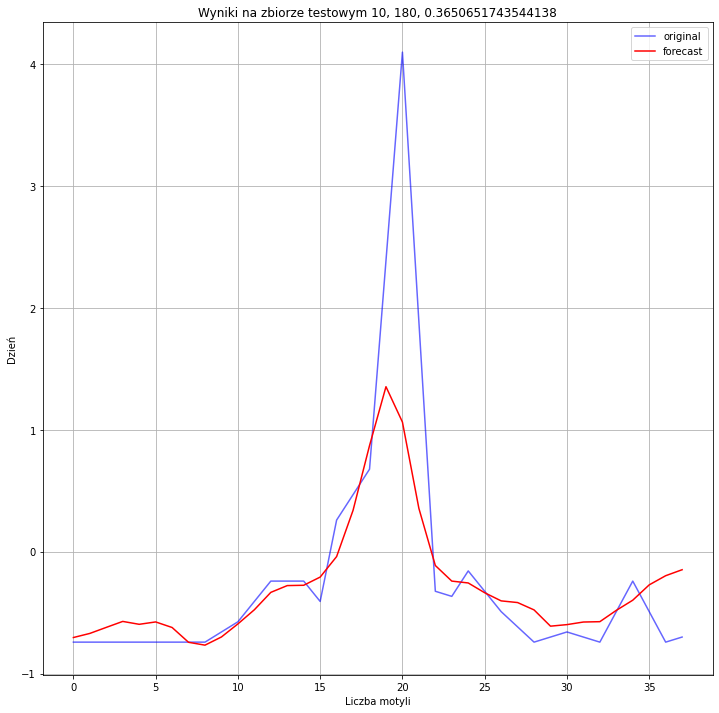

In [93]:
make_plot_for_params(y_test_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                     y_pred_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                    f'Wyniki na zbiorze testowym {elastic_net_lag}, {elastic_net_iter}, {elastic_net_mse}')

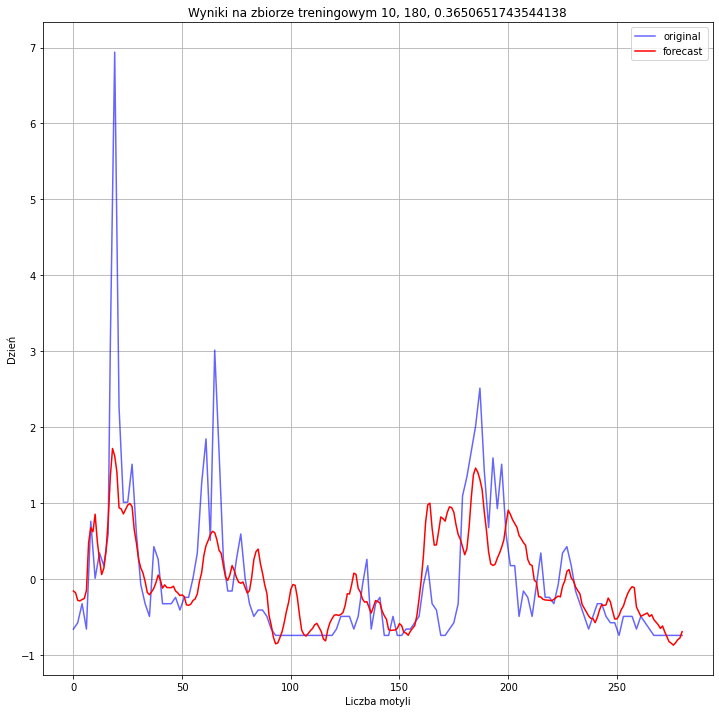

In [94]:
make_plot_for_params(y_train_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                     y_pred_train_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                    f'Wyniki na zbiorze treningowym {elastic_net_lag}, {elastic_net_iter}, {elastic_net_mse}')

## Polynomial

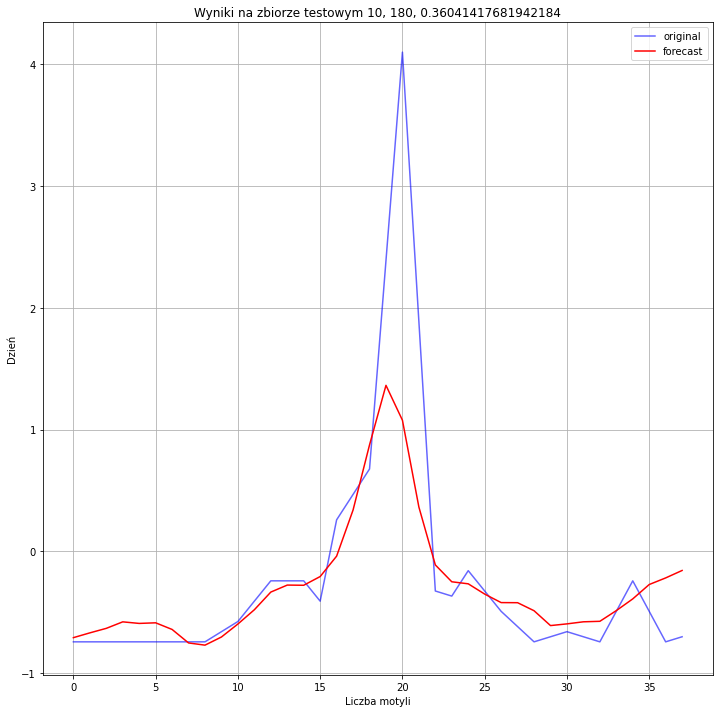

In [95]:
make_plot_for_params(y_test_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                     y_pred_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                    f'Wyniki na zbiorze testowym {poly_net_lag}, {poly_net_iter}, {poly_net_mse}')

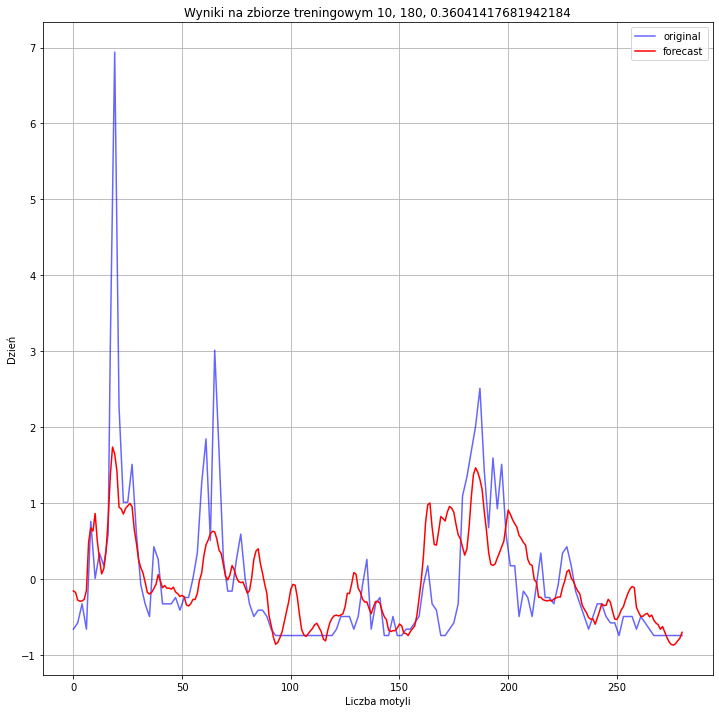

In [96]:
make_plot_for_params(y_train_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                     y_pred_train_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                    f'Wyniki na zbiorze treningowym {poly_net_lag}, {poly_net_iter}, {poly_net_mse}')

# Trening  lag = range(4, 20, 2) iterations = range(100, 400, 20), day_a_head=1

In [97]:
y_test_all, y_pred_all, y_pred_train_all, y_train_all, mse_all, mse_train = make_experements(range(4, 20, 2), range(100, 200, 20), 1)

In [98]:
elastic_net_lag, elastic_net_iter, elastic_net_mse =findBestParams(mse_all.get("ElasticNet"))
poly_net_lag, poly_net_iter, poly_net_mse =findBestParams(mse_all.get("PolynomialRidgeRegression"))

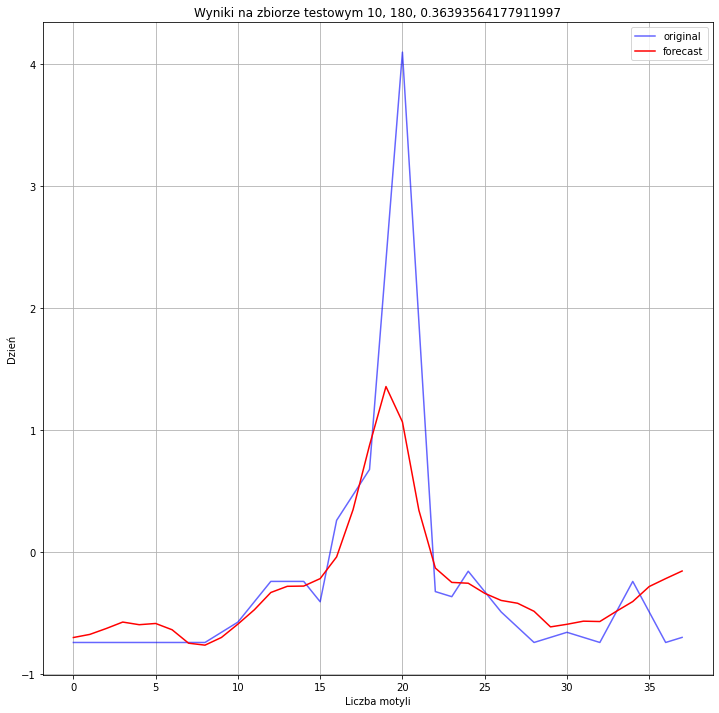

In [99]:
make_plot_for_params(y_test_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                     y_pred_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                    f'Wyniki na zbiorze testowym {elastic_net_lag}, {elastic_net_iter}, {elastic_net_mse}')

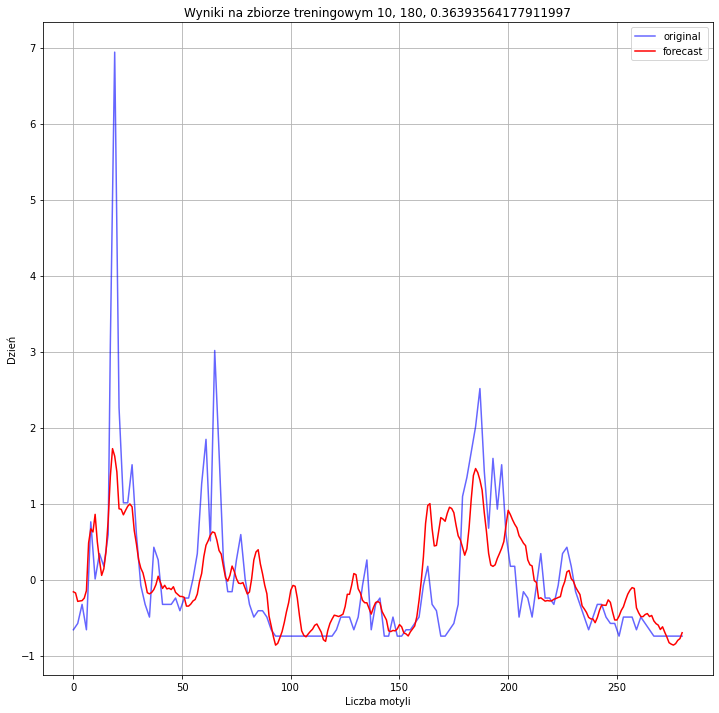

In [100]:
make_plot_for_params(y_train_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                     y_pred_train_all.get('ElasticNet').get(elastic_net_lag).get(elastic_net_iter),
                    f'Wyniki na zbiorze treningowym {elastic_net_lag}, {elastic_net_iter}, {elastic_net_mse}')

## Polynomial

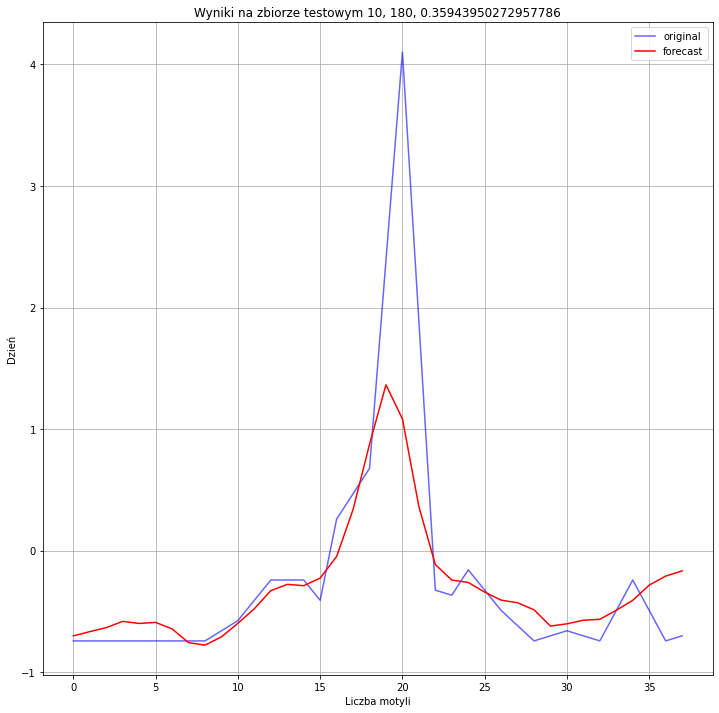

In [101]:
make_plot_for_params(y_test_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                     y_pred_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                    f'Wyniki na zbiorze testowym {poly_net_lag}, {poly_net_iter}, {poly_net_mse}')

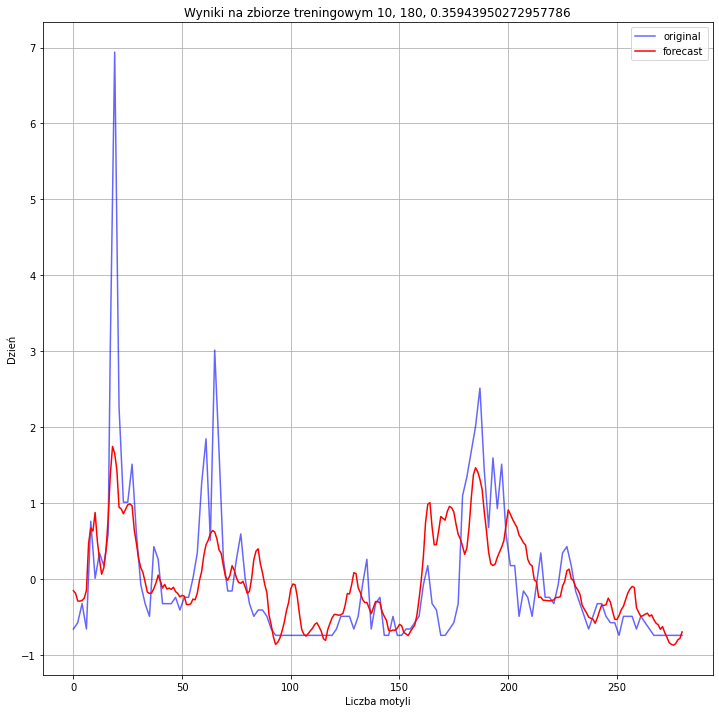

In [102]:
make_plot_for_params(y_train_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                     y_pred_train_all.get('PolynomialRidgeRegression').get(poly_net_lag).get(poly_net_iter),
                    f'Wyniki na zbiorze treningowym {poly_net_lag}, {poly_net_iter}, {poly_net_mse}')